In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196758
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
label_encoder = fs.get_transformation_function(name="label_encoder")
feature_view = fs.get_or_create_feature_view(
    name="wine",
    version=1,
    description="Read from wine quality dataset",
    labels=["quality"],
    query=query,
    transformation_functions={
        "type": label_encoder
    }
)

Issue: It seems like labels are NOT separated and "type" is NOT encoded.

In [4]:
# # You can read training data, randomly split into train/test sets of features (X) and labels (y)        
# X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# # Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
# model = KNeighborsClassifier(n_neighbors=2)
# model.fit(X_train, y_train)

In [5]:
train, test, _, _ = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.33s) 


In [6]:
#split one column as targets
def feature_target_split(df, column_name):
    features = df.drop(column_name, axis=1).reset_index(drop=True)
    targets = df[column_name].reset_index(drop=True)
    return features, targets

# One-hot encode the categorical feature
def one_hot_encoder(df, column_name):
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(drop='first',sparse=False)
    encoded_features = encoder.fit_transform(df[[column_name]])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out([column_name]))
    encoded_df = pd.concat([df.drop(column_name, axis=1), encoded_df], axis=1)
    return encoded_df

In [7]:
X_train, y_train = feature_target_split(train, 'quality')
X_test, y_test = feature_target_split(test, 'quality')
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,ph,sulphates,alcohol
0,red,11.8,0.330,0.490,3.40,0.0930,54.0,1.00020,3.30,0.76,10.70
1,white,7.5,0.420,0.190,6.90,0.0410,62.0,0.99508,3.23,0.37,10.00
2,white,7.5,0.240,0.620,10.60,0.0450,51.0,0.99779,3.16,0.44,8.80
3,red,8.6,0.685,0.100,1.60,0.0920,3.0,0.99745,3.31,0.65,9.55
4,white,6.6,0.500,0.260,11.30,0.0290,32.0,0.99302,3.27,0.78,12.90
...,...,...,...,...,...,...,...,...,...,...,...
4224,red,8.9,0.620,0.190,3.90,0.1700,51.0,0.99860,3.17,0.93,9.20
4225,white,6.5,0.115,0.290,1.95,0.0380,73.0,0.98900,3.12,0.25,12.90
4226,white,6.7,0.210,0.340,1.40,0.0490,36.0,0.99091,3.02,0.50,11.00
4227,white,5.4,0.375,0.400,3.30,0.0540,29.0,0.99482,3.42,0.52,9.10


In [8]:
X_train = one_hot_encoder(X_train, 'type')
X_test = one_hot_encoder(X_test, 'type')
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,ph,sulphates,alcohol,type_white
0,11.8,0.330,0.490,3.40,0.0930,54.0,1.00020,3.30,0.76,10.70,0.0
1,7.5,0.420,0.190,6.90,0.0410,62.0,0.99508,3.23,0.37,10.00,1.0
2,7.5,0.240,0.620,10.60,0.0450,51.0,0.99779,3.16,0.44,8.80,1.0
3,8.6,0.685,0.100,1.60,0.0920,3.0,0.99745,3.31,0.65,9.55,0.0
4,6.6,0.500,0.260,11.30,0.0290,32.0,0.99302,3.27,0.78,12.90,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4224,8.9,0.620,0.190,3.90,0.1700,51.0,0.99860,3.17,0.93,9.20,0.0
4225,6.5,0.115,0.290,1.95,0.0380,73.0,0.98900,3.12,0.25,12.90,1.0
4226,6.7,0.210,0.340,1.40,0.0490,36.0,0.99091,3.02,0.50,11.00,1.0
4227,5.4,0.375,0.400,3.30,0.0540,29.0,0.99482,3.42,0.52,9.10,1.0


In [9]:
y_train

0       7
1       6
2       5
3       6
4       8
       ..
4224    5
4225    7
4226    6
4227    5
4228    7
Name: quality, Length: 4229, dtype: int64

In [10]:
def find_thresholds(train, test, column_name):
    df = pd.concat([train, test], axis=0)
    column_list = list(df[column_name])
    column_list.sort()
    lower_threshold_idx = int(len(column_list)/3)
    upper_threshold_idx = lower_threshold_idx * 2
    lower_threshold = column_list[lower_threshold_idx]
    upper_threshold = column_list[upper_threshold_idx]
    return lower_threshold, upper_threshold

def quality2class(series, lower_threshold, upper_threshold):
    quality_list = list(series)
    class_list = []
    for i in range(len(quality_list)):
        if quality_list[i] < lower_threshold:
            class_list.append('poor')
        elif quality_list[i] > upper_threshold:
            class_list.append('excellent')
        else:
            class_list.append('fair')
    class_series= pd.Series(class_list, name = 'class')

    return class_series

In [11]:
lower_threshold, upper_threshold = find_thresholds(train, test, 'quality')
print(lower_threshold, upper_threshold)

5 6


In [12]:
y_train = quality2class(y_train, lower_threshold, upper_threshold)
y_test = quality2class(y_test, lower_threshold, upper_threshold)
y_train


0       excellent
1            fair
2            fair
3            fair
4       excellent
          ...    
4224         fair
4225    excellent
4226         fair
4227         fair
4228    excellent
Name: class, Length: 4229, dtype: object

In [13]:
# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
# Use Scikit-learn RandomizedSearchCV to fine-tune the hyperparameters in order to optimise the model

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters grid
param_dist = {
    'n_neighbors': randint(1, 50),
    'p': [1, 2],
    'weights': ["uniform", "distance"],
}

# Create a KNN Classifier
knn = KNeighborsClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=50, cv=5)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Hyperparameters::\n{}".format(random_search.best_params_))
print("\nHighest Cross Validation Score::{}".format(random_search.best_score_))

# Evaluate model performance using the features from the test set (X_test)
model = random_search.best_estimator_
y_pred = model.predict(X_test)

# Calculate the accuracy of the best model
print("\nTesting Accuracy::{}".format(accuracy_score(y_test, y_pred)))

Best Hyperparameters::
{'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

Highest Cross Validation Score::0.7746521745212417

Testing Accuracy::0.775992438563327


In [14]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)
results = confusion_matrix(y_test, y_pred)

In [15]:
print(metrics)

{'excellent': {'precision': 0.5362318840579711, 'recall': 0.18686868686868688, 'f1-score': 0.27715355805243447, 'support': 198}, 'fair': {'precision': 0.7922998986828774, 'recall': 0.9606879606879607, 'f1-score': 0.8684064408661856, 'support': 814}, 'poor': {'precision': 1.0, 'recall': 0.043478260869565216, 'f1-score': 0.08333333333333333, 'support': 46}, 'accuracy': 0.775992438563327, 'macro avg': {'precision': 0.7761772609136162, 'recall': 0.39701163614207097, 'f1-score': 0.4096311107506511, 'support': 1058}, 'weighted avg': {'precision': 0.7534083464757472, 'recall': 0.775992438563327, 'f1-score': 0.7236224770253218, 'support': 1058}}


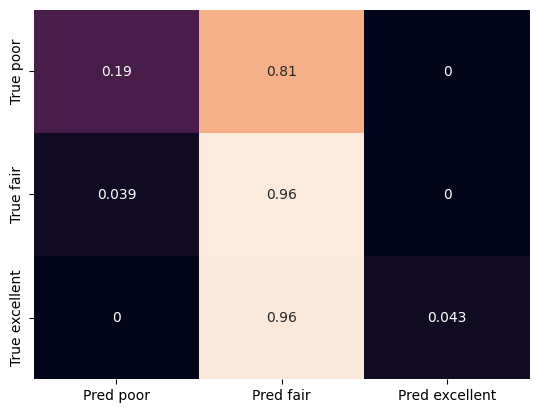

In [16]:
import numpy as np

# Normalise confusion matrix
results_norm = results.astype('float') / results.sum(axis=1)[:, np.newaxis]

# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results_norm, ['True poor', 'True fair', 'True excellent'],
                     ['Pred poor', 'Pred fair', 'Pred excellent'])
cm = sns.heatmap(df_cm, annot=True, cbar=False)
fig = cm.get_figure()

In [17]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_class_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_class_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_class_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_class_model = mr.python.create_model(
    name="wine_class_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="wine class Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_class_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/16392 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/850262 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1047 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/196758/models/wine_class_model/1


Model(name: 'wine_class_model', version: 1)